# **NASA MODIS Terra NDVI, Collection 6.1 using pyModis**
require minimum 5 columns: LATDD83, LONGDD83, YEAR, MONTH, DAY

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd
df = pd.read_csv('gdrive/My Drive/nowildfire.csv')
df = df.drop(columns=['Unnamed: 0'])

In [ ]:
df.head(10)

,LATDD83,LONGDD83,YEAR,MONTH,DAY,fire,TEMP_MAX,TEMP_MIN,AVG_RELATIVE_HUMIDITY,AVG_10M_WIND,...,AVG_PRECIPITATION,APPARENT_TEMP,CLOUD_LOW,CLOUD_HIGH,CLOUD_MID,CLOUD,AVG_WEATHER_CONDITION,AVG_SOIL_TEMP,AVG_SOIL_MOISTURE,ELEVATION
0,32.567927,-109.885445,2023,3,18,0,56.072300,36.992302,54.880222,14.157670,...,0.004167,37.486279,27.791666,28.500000,8.250000,43.416668,0.0,51.842300,0.263458,1488.0
1,47.195568,-112.708439,2022,4,7,0,44.241798,14.901798,59.511341,7.067084,...,0.000000,19.254007,0.000000,39.958332,6.375000,42.083332,2.0,32.395550,0.334917,1988.0
2,34.950160,-114.750660,2022,9,20,0,97.599197,72.129204,18.746798,8.228768,...,0.000000,80.679665,0.000000,0.000000,4.958333,4.833333,0.0,91.010445,0.000000,415.0
3,39.085396,-107.714605,2023,6,27,0,61.292297,50.762299,26.994581,23.090561,...,0.000000,45.404552,0.000000,0.791667,16.500000,16.291666,0.0,48.583553,0.419792,3238.0
4,39.308223,-102.862096,2023,10,2,0,80.744904,61.484898,52.470245,30.046616,...,0.104167,62.661591,0.958333,19.958334,5.750000,21.791666,0.0,72.862404,0.135250,1426.0
5,34.961509,-114.208403,2023,5,16,0,94.382607,71.792603,22.465042,10.090797,...,0.000000,80.437500,0.083333,53.500000,19.250000,64.041664,2.0,89.522606,0.023000,619.0
6,31.360759,-108.597024,2021,7,28,0,90.933792,66.183800,46.847256,8.270101,...,0.000000,76.940857,0.000000,25.333334,11.708333,34.416668,1.0,84.855049,0.263375,1530.0
7,47.072182,-97.679354,2023,3,10,0,29.448500,23.238499,87.683952,13.249466,...,0.079167,17.428843,72.541664,78.208336,53.458332,95.750000,3.0,26.696001,0.227000,352.0
8,35.506113,-113.888563,2021,4,9,0,80.029396,54.829399,10.988235,9.668028,...,0.000000,62.349628,0.000000,16.458334,0.000000,16.458334,0.0,71.550652,0.028917,917.0
9,42.827392,-111.574628,2021,12,2,0,47.192001,30.002001,79.691605,9.307274,...,0.000000,29.713982,0.000000,6.541667,0.000000,5.791667,0.0,32.559498,0.246500,1877.0


In [ ]:
# DON'T RUN. backup install for pyModis
# !git clone https://github.com/lucadelu/pyModis.git
# !python pyModis/setup.py install

In [ ]:
!pip install pymodis rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 37.1 MB/s eta 0:00:00


In [51]:
from ast import Assert
import os
import pandas as pd
from datetime import datetime, timedelta, date
from pymodis.downmodis import downModis
from pymodis.convertmodis_gdal import convertModisGDAL
import rasterio
from rasterio.warp import transform
from rasterio.transform import rowcol

import math

CELLS = 2400
VERTICAL_TILES = 18
HORIZONTAL_TILES = 36
EARTH_RADIUS = 6371007.181
EARTH_WIDTH = 2 * math.pi * EARTH_RADIUS

TILE_WIDTH = EARTH_WIDTH / HORIZONTAL_TILES
TILE_HEIGHT = TILE_WIDTH
CELL_SIZE = TILE_WIDTH / CELLS

from pyproj import Proj

MODIS_GRID = Proj(f"+proj=sinu +R={EARTH_RADIUS} +nadgrids=@null +wktext")


def point_to_tile(lat, lon):
    x, y = MODIS_GRID(lon, lat)
    h = (EARTH_WIDTH * 0.5 + x) / TILE_WIDTH
    v = -(EARTH_WIDTH * 0.25 + y - (VERTICAL_TILES - 0) * TILE_HEIGHT) / TILE_HEIGHT
    return int(h), int(v)


def convert_hdf_to_geotiff(hdf_path, sds_name="250m-16-days-ndvi"):
    """
    Convert the specified subdataset in the HDF to a GeoTIFF in EPSG:4326.
    """
    output_tif = hdf_path.replace(".hdf", f"_{sds_name}.tif").replace(" ", "_")
    if os.path.exists(output_tif):
        # Already converted
        return output_tif

    # missing documentation. Closest is convert()
    # http://www.pymodis.org/scripts/modis_convert.html
    converter = convertModisGDAL(
        hdfname=hdf_path,
        outformat="GTiff",
        prefix=hdf_path.replace(".hdf", ""),
        epsg=4326,  # reproject to lat/lon
        res=None,
        subset=[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        # filter for subdataset "250m 16 days NDVI"
    )

    converter.run(quiet=True)
    return output_tif


def sample_ndvi(geotiff_path, lat, lon, nodata_value=-3000, scale=0.0001):
    """
    Read NDVI pixel from a GeoTIFF at given lat/lon (in WGS84).
    Returns scaled NDVI or -1 if out of bounds or fill/nodata.

    default:
      nodata_value = -3000
      scale = 0.001
    """
    with rasterio.open(geotiff_path) as src:
        # Convert lon/lat to row/col
        row, col = rowcol(src.transform, lon, lat)

        if row < 0 or row >= src.height or col < 0 or col >= src.width:
            return -1

        # Read the pixel
        ndvi_array = src.read(1)
        val = ndvi_array[row, col]

        if val == src.nodata or val == nodata_value:
            return -1

        # Apply scale factor
        val = val * scale
        return val


def get_geotiff_path(h, v, yyyy, doy, sds_name="250m-16-days-ndvi", out_dir="MODIS_data"):
    """
    Given tile (h,v), date, and SDS name, build the expected GeoTIFF filename.
    This depends on how the .hdf is named after download.
    exmaple (hdf -> tif):
      MOD13Q1.A2023349.h11v03.061.2023360202430.hdf
      MOD13Q1.A2023349.h11v03.061.2023360202430_250m-16-days-ndvi.tif
    """
    # naive approach
    base_pattern = f"h{int(h):02d}v{int(v):02d}"

    for root, dirs, files in os.walk(out_dir):
        for f in files:
            # look for a file containing tile pattern and within 16 days of doy
            # example: MOD13Q1.A2022193.h10v04.061.2022215010252_250m-16-days-ndvi.tif
            if f.endswith(f"{sds_name}.tif") and base_pattern in f:
                try:
                  fstr = f.split(".")[1]
                  Assert(len(fstr) == 8)
                except:
                  print("AN ERROR HAS OCCURED: incorrect .tif format: ", f)
                  continue
                f_yyyy = int(fstr[1:5])
                f_doy = int(fstr[5:])
                f_date = get_date_from_doy(f_yyyy, f_doy)
                c_date = get_date_from_doy(yyyy, doy)
                date_delta = (c_date - f_date).days
                if date_delta >= 0 and date_delta < 16:
                  return os.path.join(root, f)
            else:
              if not f.endswith(f"{sds_name}.tif"):
                print("tif error")
    return None


def remove_suffix_in_MODIS_data(suf):
    """
    Remove all files that end with ".'suf'" in MODIS_data
    """
    cwd = os.getcwd()
    dir_name = os.path.join(cwd, "MODIS_data")
    modis_data = os.listdir(dir_name)

    for item in modis_data:
        if item.endswith("." + suf):
            os.remove(os.path.join(dir_name, item))

def get_date_from_doy(yyyy, doy):
    return (datetime(yyyy, 1, 1) + timedelta(days=doy - 1)).date()


In [ ]:
def date_to_doy(year, month, day):
    return datetime(int(year), int(month), int(day)).strftime("%j")

# For each row, find (h, v) tile and the day-of-year
def get_tile_date_info(row):
    h, v = point_to_tile(row["LATDD83"], row["LONGDD83"])
    doy = date_to_doy(row["YEAR"], row["MONTH"], row["DAY"])
    return h, v, doy

df[["h", "v", "doy"]] = df.apply(
    lambda r: pd.Series(get_tile_date_info(r)),
    axis=1
)

# We can group by (h, v, YEAR, MONTH, DAY, doy) to know each tile-date combination we need
tile_date_groups = df.groupby(["h", "v", "YEAR", "MONTH"])

tile_date_groups.head()

,LATDD83,LONGDD83,YEAR,MONTH,DAY,fire,TEMP_MAX,TEMP_MIN,AVG_RELATIVE_HUMIDITY,AVG_10M_WIND,...,CLOUD_HIGH,CLOUD_MID,CLOUD,AVG_WEATHER_CONDITION,AVG_SOIL_TEMP,AVG_SOIL_MOISTURE,ELEVATION,h,v,doy
0,32.567927,-109.885445,2023,3,18,0,56.072300,36.992302,54.880222,14.157670,...,28.500000,8.250000,43.416668,0.0,51.842300,0.263458,1488.0,8,5,077
1,47.195568,-112.708439,2022,4,7,0,44.241798,14.901798,59.511341,7.067084,...,39.958332,6.375000,42.083332,2.0,32.395550,0.334917,1988.0,10,4,097
2,34.950160,-114.750660,2022,9,20,0,97.599197,72.129204,18.746798,8.228768,...,0.000000,4.958333,4.833333,0.0,91.010445,0.000000,415.0,8,5,263
3,39.085396,-107.714605,2023,6,27,0,61.292297,50.762299,26.994581,23.090561,...,0.791667,16.500000,16.291666,0.0,48.583553,0.419792,3238.0,9,5,178
4,39.308223,-102.862096,2023,10,2,0,80.744904,61.484898,52.470245,30.046616,...,19.958334,5.750000,21.791666,0.0,72.862404,0.135250,1426.0,10,5,275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19349,25.323621,-80.763161,2023,1,5,0,84.066795,67.416794,80.211708,9.005922,...,22.458334,0.958333,22.875000,0.0,76.146797,0.103542,0.0,10,6,005
19367,28.203178,-81.436587,2021,8,24,0,87.811699,76.381699,85.001404,6.144155,...,95.250000,66.375000,97.750000,3.0,81.886696,0.233333,21.0,10,6,236
19369,28.368494,-81.976497,2021,3,20,0,67.921700,53.971699,73.076576,14.177795,...,0.000000,5.875000,50.916668,0.0,62.772949,0.081875,36.0,10,6,079
19661,46.155184,-86.203871,2023,3,26,0,38.186600,23.696600,75.913567,11.866425,...,34.916668,15.458333,51.083332,3.0,30.825348,0.265000,208.0,12,4,085


In [ ]:
from google.colab import userdata

NASA_USER = userdata.get('NASA_USER')
NASA_PASS = userdata.get('NASA_PASS')
PRODUCT = "MOD13Q1.061"  # Terra NDVI, Collection 6.1

destination_folder = "MODIS_data"
os.makedirs(destination_folder, exist_ok=True)

print("setup complete!")

unique_tile_dates = tile_date_groups.size().reset_index(name='occ').sort_values(by=['occ'], ascending=False)
print("len: ", len(unique_tile_dates))
unique_tile_dates.head() # expected columns: h, v, YEAR, doy, occ

setup complete!
len:  307


,h,v,YEAR,MONTH,occ
174,10,4,2023,7,219
162,10,4,2022,7,217
175,10,4,2023,8,215
177,10,4,2023,10,214
173,10,4,2023,6,214


In [ ]:
from tqdm import tqdm
import calendar
tqdm.pandas()

def down_batch(batch_tile_dates):
  for idx, row in tqdm(batch_tile_dates.iterrows()):
      h = row["h"]
      v = row["v"]
      year = row["YEAR"]
      month = row["MONTH"]

      foo, numDaysInMonth = calendar.monthrange(year, month)


      today = f"{year}-{str(month).zfill(2)}-01"
      enddate = f"{year}-{str(month).zfill(2)}-{numDaysInMonth}"

      # tile format example: h11v03
      tile_str = f"h{int(h):02d}v{int(v):02d}"

      dm = downModis(
          destinationFolder=destination_folder,
          user=NASA_USER,
          password=NASA_PASS,
          tiles=tile_str,
          path="MOLT",
          product=PRODUCT,
          today=today,
          enddate=enddate,
          delta=0,
          debug=False,
          checkgdal=False
      )
      try:
          dm.connect()
          dm.downloadsAllDay()
      except:
          # no data on that day
          pass

  remove_suffix_in_MODIS_data("xml")

In [ ]:
# convert to geotiff after bulk download
def convert_MODIS_data_to_tiff():
  for root, dirs, files in os.walk(destination_folder):
    for f in files:
      if f.endswith(".hdf"):
        hdf_path = os.path.join(root, f)
        convert_hdf_to_geotiff(hdf_path, "250m 16 days NDVI")

  remove_suffix_in_MODIS_data("hdf")
  remove_suffix_in_MODIS_data("txt")

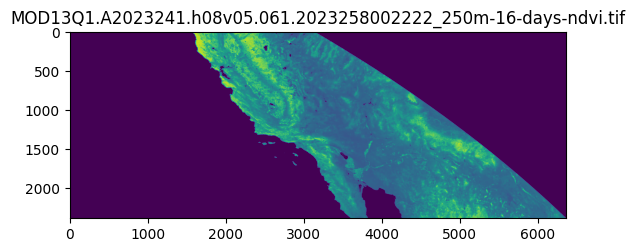

In [ ]:
# import random
# import matplotlib.pyplot as plt
# import tifffile

# f = random.choice(os.listdir("./MODIS_data"))

# im = tifffile.imread(os.path.join("./MODIS_data", f))

# plt.imshow(im)
# plt.title(f)
# plt.show()

In [ ]:
def retrieve_ndvi_values():
  ndvi_cnt = 0;
  none_cnt = 0
  ndvi_values = []
  for idx, row in df.iterrows():
      h, v = row["h"], row["v"]
      yyyy, doy = int(row["YEAR"]), int(row["doy"])
      lat, lon = row["LATDD83"], row["LONGDD83"]

      geotiff_path = get_geotiff_path(h, v, yyyy, doy)
      if geotiff_path is None:
          none_cnt+=1
          ndvi_values.append(None)
          continue

      ndvi_cnt+=1
      val = sample_ndvi(geotiff_path, lat, lon)
      ndvi_values.append(val)

  df["NDVI"] = ndvi_values
  return ndvi_cnt, none_cnt

In [53]:
# NDVI values None: no data for this location (figure out how to handle this later)
# NDVI values below 0: This indicates water or other non-vegetated features.
# NDVI values between 0 and 0.3: This indicates barren areas with little to no vegetation cover.
# NDVI values between 0.3 and 0.6: This indicates areas with sparse vegetation cover.
# NDVI values between 0.6 and 0.9: This indicates areas with dense and healthy vegetation cover.
# NDVI values above 0.9: This indicates areas with very dense vegetation cover, such as rainforests.
# source: https://www.farm21.com/ndvi-images-ultimate-3-step-guide/

BATCH_SIZE = 5 # default 5 higher prob work idk
NUM_BATCHES =  math.ceil(len(unique_tile_dates)/BATCH_SIZE) # change this value. default: math.ceil(len(unique_tile_dates)/BATCH_SIZE)
START_BATCH = 0 # default 0

for batch_num in range(START_BATCH,NUM_BATCHES):
  batch_tile_dates = unique_tile_dates[batch_num * BATCH_SIZE:(batch_num+1) * BATCH_SIZE]
  down_batch(batch_tile_dates)
  convert_MODIS_data_to_tiff()
  ndvi_cnt,none_cnt = retrieve_ndvi_values()

  # filtered_df = df[df.NDVI.notnull()]
  # Now df has an NDVI column with the extracted values.
  df.to_csv(f"points_with_ndvi_batch_{batch_num}.csv", index=False)
  # print("none_cnt: ", none_cnt)
  print(f"Batch {batch_num} complete! with {ndvi_cnt} entries")
  remove_suffix_in_MODIS_data("tif")



5it [01:57, 23.49s/it]


Batch 0 complete! with 986 entries


5it [01:54, 22.81s/it]


Batch 1 complete! with 1095 entries


5it [01:49, 21.80s/it]


Batch 2 complete! with 1053 entries


5it [01:56, 23.34s/it]


Batch 3 complete! with 1057 entries


5it [01:52, 22.49s/it]


Batch 4 complete! with 912 entries


5it [01:48, 21.68s/it]


Batch 5 complete! with 1026 entries


5it [01:57, 23.54s/it]


Batch 6 complete! with 887 entries


5it [01:47, 21.45s/it]


Batch 7 complete! with 696 entries


5it [01:39, 19.94s/it]


Batch 8 complete! with 615 entries


5it [01:34, 18.86s/it]


Batch 9 complete! with 614 entries


5it [01:38, 19.64s/it]


Batch 10 complete! with 592 entries


5it [01:17, 15.43s/it]


Batch 11 complete! with 471 entries


5it [01:44, 20.90s/it]


Batch 12 complete! with 576 entries


5it [01:21, 16.40s/it]


Batch 13 complete! with 479 entries


5it [01:43, 20.75s/it]


Batch 14 complete! with 537 entries


5it [01:31, 18.23s/it]


Batch 15 complete! with 524 entries


5it [01:34, 18.81s/it]


Batch 16 complete! with 469 entries


5it [01:41, 20.27s/it]


Batch 17 complete! with 526 entries


5it [01:25, 17.05s/it]


Batch 18 complete! with 420 entries


5it [01:55, 23.06s/it]


Batch 19 complete! with 465 entries


5it [01:53, 22.69s/it]


Batch 20 complete! with 471 entries


5it [02:00, 24.03s/it]


Batch 21 complete! with 405 entries


5it [01:37, 19.44s/it]


Batch 22 complete! with 483 entries


5it [02:04, 24.87s/it]


Batch 23 complete! with 354 entries


5it [01:29, 17.97s/it]


Batch 24 complete! with 456 entries


5it [01:41, 20.27s/it]


Batch 25 complete! with 387 entries


5it [01:49, 21.98s/it]


Batch 26 complete! with 440 entries


5it [01:52, 22.47s/it]


Batch 27 complete! with 429 entries


5it [01:38, 19.69s/it]


Batch 28 complete! with 373 entries


5it [01:47, 21.52s/it]


Batch 29 complete! with 252 entries


5it [01:56, 23.28s/it]


Batch 30 complete! with 263 entries


5it [01:49, 21.89s/it]


Batch 31 complete! with 217 entries


5it [01:34, 18.82s/it]


Batch 32 complete! with 204 entries


5it [01:45, 21.10s/it]


Batch 33 complete! with 197 entries


5it [01:23, 16.70s/it]


Batch 34 complete! with 153 entries


5it [01:56, 23.31s/it]


Batch 35 complete! with 160 entries


5it [00:44,  8.84s/it]


Batch 36 complete! with 77 entries


5it [00:47,  9.42s/it]


Batch 37 complete! with 86 entries


5it [00:42,  8.52s/it]


Batch 38 complete! with 66 entries


5it [00:44,  8.82s/it]


Batch 39 complete! with 75 entries


5it [01:59, 23.81s/it]


Batch 40 complete! with 60 entries


5it [01:07, 13.58s/it]


Batch 41 complete! with 60 entries


5it [01:19, 15.84s/it]


Batch 42 complete! with 54 entries


5it [02:18, 27.78s/it]


Batch 43 complete! with 50 entries


5it [03:49, 45.87s/it]


Batch 44 complete! with 39 entries


5it [03:45, 45.11s/it]


Batch 45 complete! with 44 entries


5it [02:06, 25.28s/it]


Batch 46 complete! with 40 entries


5it [04:47, 57.51s/it]


Batch 47 complete! with 37 entries


5it [02:06, 25.38s/it]


Batch 48 complete! with 25 entries


5it [01:49, 21.81s/it]


Batch 49 complete! with 25 entries


5it [02:21, 28.24s/it]


Batch 50 complete! with 25 entries


5it [00:52, 10.60s/it]


Batch 51 complete! with 15 entries


5it [01:16, 15.22s/it]


Batch 52 complete! with 15 entries


5it [01:54, 22.86s/it]


Batch 53 complete! with 10 entries


5it [02:38, 31.64s/it]


Batch 54 complete! with 13 entries


5it [01:03, 12.73s/it]


Batch 55 complete! with 14 entries


5it [00:55, 11.10s/it]


Batch 56 complete! with 9 entries


5it [02:19, 27.97s/it]


Batch 57 complete! with 4 entries


5it [01:57, 23.50s/it]


Batch 58 complete! with 4 entries


5it [02:01, 24.39s/it]


Batch 59 complete! with 6 entries


5it [01:39, 19.82s/it]


Batch 60 complete! with 5 entries


2it [00:28, 14.16s/it]


Batch 61 complete! with 2 entries


In [47]:
# After every batch pls rm -rf MODIS_data each file is like 30-100 MB

# !rm -rf MODIS_data
# os.makedirs(destination_folder, exist_ok=True)
# print("occ sum: ", unique_tile_dates[0:5]['occ'].sum())